# Dimensionality Reduction with the Proper Orthogonal Decomposition (POD) and Sensor Positioning with SGREEDY
This notebook takes the Snapshots, compress the data using the POD and selects the sensor positions using the SGREEDY algorithm.

Let us create the mesh from the OpenFOAM nodes and cells

In [ ]:
from pyforce.tools.write_read import ReadFromOF
from IPython.display import clear_output as clc

from matplotlib import cm, pyplot as plt
import pickle

path_snaps = '../../../Data/MSFR/'
of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('../ReflectorSensing/Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('../ReflectorSensing/Results/times.npz')['fom_times']

measured_filed = [0]
var_names = [var_names[i] for i in measured_filed]
is_vector = [is_vector[i] for i in measured_filed]

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('../ReflectorSensing/Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.25, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

train_snaps = dict()

for field_i, field in enumerate(var_names):
    train_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in train_indices:
        train_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

## POD Training Phase
Let us compute the POD modes using the randomized SVD method.

In [4]:
from pyforce.offline.pod import POD

pod_offline = {
    field: POD(train_snap=train_snaps[field], name=field, verbose=True)
    for field in var_names
}

Computing T correlation matrix: 206.000 / 206.00 - 1.059 s/it


Let us plot the singular values and the cumulative energy

Text(0, 0.5, 'Residual energy')

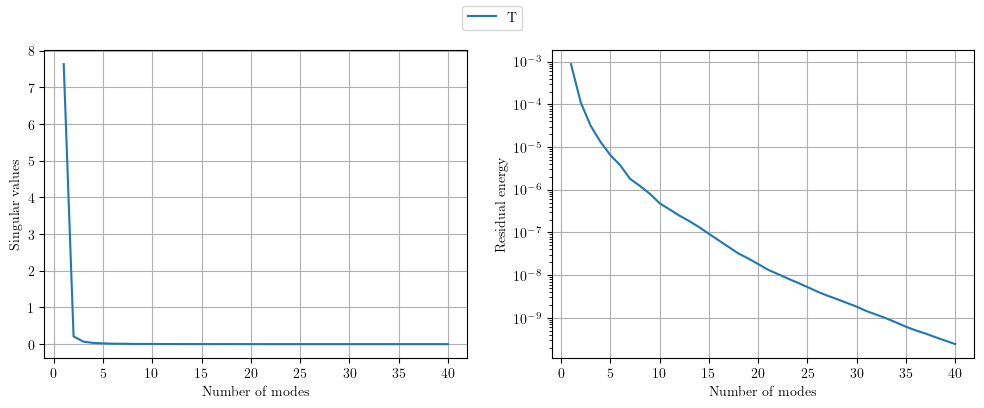

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12, 4))

Nplot=np.arange(1, 41)
for field in var_names:
    axs[0].plot(Nplot, np.sqrt(pod_offline[field].eigenvalues[:max(Nplot)]), label=field)
    axs[1].semilogy(Nplot, 1 - np.cumsum(pod_offline[field].eigenvalues)[:max(Nplot)]/np.sum(pod_offline[field].eigenvalues), label=field)

Lines, Labels = axs[0].get_legend_handles_labels()
fig.legend(Lines, Labels, loc='upper center', ncols=4)

for ax in axs:
    ax.set_xlabel('Number of modes')
    ax.grid()
axs[0].set_ylabel('Singular values')
axs[1].set_ylabel('Residual energy')

Let us project the snapshots onto the POD modes to obtain the coefficients.

In [6]:
max_rank = 15

for field in var_names:
    pod_offline[field].compute_basis(train_snap=train_snaps[field], maxBasis=max_rank)

Let us generate and store the POD modes

In [7]:
import os
from pyforce.tools.write_read import StoreFunctionsList

path_offline = 'Results/POD_offline/'
os.makedirs(path_offline, exist_ok=True)

for field in var_names:
    StoreFunctionsList(domain, pod_offline[field].PODmodes, f'POD_{field}_modes', 
                       path_offline+f'POD_{field}_modes')


Let us plot the POD modes

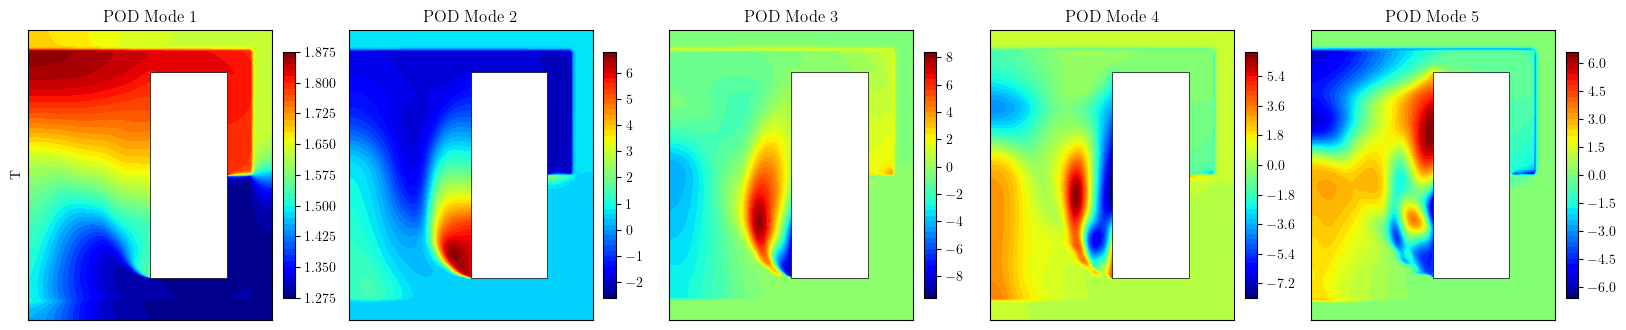

In [8]:
from utils import plot_contour
from matplotlib import cm

mode_to_plot = np.arange(0, 5, 1)

mesh_to_plot = np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]], axis=1)

nrows = len(var_names)
ncols = len(mode_to_plot)

cmaps = [cm.jet]

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axs = axs.reshape(nrows, ncols)

for row, field in enumerate(var_names):
    for col in range(ncols):
        mode = pod_offline[field].PODmodes(mode_to_plot[col])
        vec_mode_to_plot = True if is_vector[row] else None
        cont = plot_contour(axs[row, col], mesh_to_plot, mode, levels=50, vec_mode_to_plot=vec_mode_to_plot, cmap=cmaps[row])
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(f'{var_names[row]}')
    for col in range(ncols):
        axs[0, col].set_title(f'POD Mode {mode_to_plot[col]+1}')

## SGRREDY algorithm
To place sensors inside the domain, we will use the SGREEDY algorithm.

In [9]:
from pyforce.offline.sensors import SGREEDY

s = 0.025

sgreedy_offline = {
    field: SGREEDY(domain, pod_offline[field].PODmodes, fun_spaces[field_i], field, s=s)
    for field_i, field in enumerate(var_names)
}

Let us compute the positions of the sensors using the SGREEDY algorithm.

In [10]:
Nmax = 10
Mmax = 15

def is_out_core(node):
    return (((node[2] <= -1.13) or (node[2] >=  1.13) or (node[0] >= 2.05)) and
            ((node[1]<=0.02) or (node[1]>=-0.02)))

nodes = domain.geometry.x
out_core = np.array([is_out_core(node) for node in nodes])
out_core_idx = np.where(out_core)[0]
in_core_idx  = np.where(~out_core)[0]

xm_list = list()
for tag in in_core_idx[::50]:
    xm_list.append(nodes[tag])

for field in var_names:
    sgreedy_offline[field].generate(Nmax, Mmax, tol=0.5, verbose=True, xm=xm_list, is_H1=False)

Generating sensors (coinstrained cells): 1346.000 / 1346.00 - 0.015 s/it
m = 15, n = 10 | beta_n,m = 0.000478


Let us plot the sensors

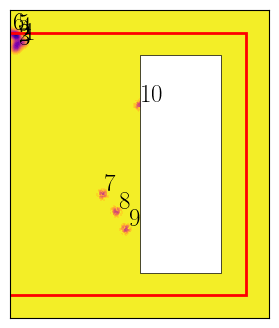

In [11]:
from matplotlib import patches

sens_to_plot = 10

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ms = np.zeros(train_snaps[field].fun_shape)

locs = list()
for mm in range(sens_to_plot):
    ms += sgreedy_offline[field].basis_sens(mm) / np.max(sgreedy_offline[field].basis_sens(mm))
    locs.append(np.argmax(sgreedy_offline[field].basis_sens(mm)))
points = np.stack([domain.geometry.x[locs, 0], domain.geometry.x[locs, 2]]).T
labels = [str(mm+1) for mm in range(sens_to_plot)]
cont = plot_contour(axs, 
                    np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]]).T, 
                    ms, levels=20, cmap=cm.plasma_r)
# axs.scatter(points[:, 0], points[:, 1], c='black', s=20, label='Sensors')

rec = patches.Rectangle((0, -2.26 / 2), 2.05, 2.26, linewidth=2, facecolor='none', edgecolor='red')
axs.add_patch(rec)

offset = 0.025
for (x, y), label in zip(points, labels):
    axs.text(x + offset, y + offset, label, fontsize=18, color='black')

Let us store the basis sensors

In [12]:
for field in var_names:
    StoreFunctionsList(domain, sgreedy_offline[field].basis_sens,
                       f'SGREEDY_{field}_sensors', path_offline+f'SGREEDY_{field}_sensors')

Let us compute the inf-sup constant for the PBDW

In [13]:
from pyforce.offline.pbdw import PBDW

pbdw_offline = {
    field: PBDW(pod_offline[field].PODmodes, sgreedy_offline[field].basis_sens)
    for field in var_names
}

infsup_constant = dict()
for field in var_names:
    infsup_constant[field] = pbdw_offline[field].compute_infsup(Nmax, Mmax)

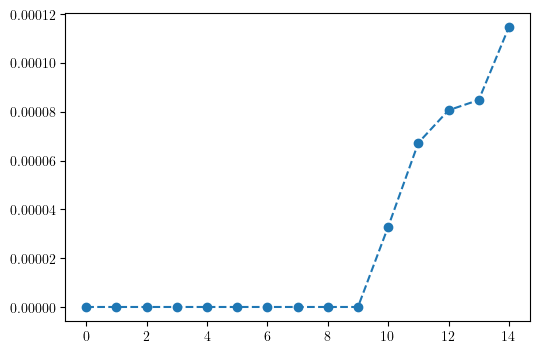

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(infsup_constant[field], '--o', label=field)